In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

trainx_dir = 'C:\\Users\\Pujari\\Downloads\\archive (1)\\ph2_dataset\\trainx'
trainy_dir = 'C:\\Users\\Pujari\\Downloads\\archive (1)\\ph2_dataset\\trainy'

def load_data(img_dir, mask_dir, img_size):
    img_paths = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir)])
    mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

    images = [img_to_array(load_img(img, target_size=img_size)) for img in img_paths]
    masks = [img_to_array(load_img(mask, target_size=img_size, color_mode='grayscale')) for mask in mask_paths]

    images = np.array(images, dtype=np.float32) / 255.0
    masks = np.array(masks, dtype=np.float32) / 255.0

    return images, masks

def build_inception_resnetv2_unet(input_shape):
    from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate, Input, ZeroPadding2D
    from tensorflow.keras.models import Model
    from tensorflow.keras.applications import InceptionResNetV2

    def conv_block(input, num_filters):
        x = Conv2D(num_filters, 3, padding="same")(input)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Conv2D(num_filters, 3, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x

    def decoder_block(input, skip_features, num_filters):
        x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
        x = Concatenate()([x, skip_features])
        x = conv_block(x, num_filters)
        return x

    inputs = Input(input_shape)
    encoder = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs)

    s1 = encoder.get_layer("input_1").output
    s2 = encoder.get_layer("activation").output
    s2 = ZeroPadding2D(((1, 0), (1, 0)))(s2)
    s3 = encoder.get_layer("activation_3").output
    s3 = ZeroPadding2D((1, 1))(s3)
    s4 = encoder.get_layer("activation_74").output
    s4 = ZeroPadding2D(((2, 1), (2, 1)))(s4)
    b1 = encoder.get_layer("activation_161").output
    b1 = ZeroPadding2D((1, 1))(b1)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="InceptionResNetV2_U-Net")

    return model

def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    iou = intersection / (union + tf.keras.backend.epsilon())
    return iou


img_size = (256, 256)
images, masks = load_data(trainx_dir, trainy_dir, img_size)


train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)


train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks)).batch(8).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks)).batch(8).prefetch(tf.data.experimental.AUTOTUNE)


input_shape = (256, 256, 3)
model = build_inception_resnetv2_unet(input_shape)


model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[iou_metric])


checkpoint = ModelCheckpoint('unet_model.h5', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience=10, verbose=1)


history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)
model.save('1st.h5')





Epoch 1/10


20/20 [==============================] - ETA: 0s - loss: 0.3187 - iou_metric: 0.5700 
Epoch 1: val_loss improved from inf to 26.09595, saving model to unet_model.h5


c:\Users\Pujari\Anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 420s 19s/step - loss: 0.3187 - iou_metric: 0.5700 - val_loss: 26.0960 - val_iou_metric: 5.9620e-06
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 0.2131 - iou_metric: 0.7008 
Epoch 2: val_loss did not improve from 26.09595
20/20 [==============================] - 224s 11s/step - loss: 0.2131 - iou_metric: 0.7008 - val_loss: 83710992.0000 - val_iou_metric: 0.0000e+00
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 0.1686 - iou_metric: 0.7385 
Epoch 3: val_loss did not improve from 26.09595
20/20 [==============================] - 220s 11s/step - loss: 0.1686 - iou_metric: 0.7385 - val_loss: 539.1008 - val_iou_metric: 0.0195
Epoch 4/10
20/20 [==============================] - ETA: 0s - loss: 0.1456 - iou_metric: 0.7636 
Epoch 4: val_loss did not improve from 26.09595
20/20 [==============================] - 223s 11s/step - loss: 0.1456 - iou_metric: 0.7636 - val_loss: 1819.8180 - val_iou_metric: 1.2838e-07


1/1 [==============================] - 1s 880ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 1s 627ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 1s 595ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


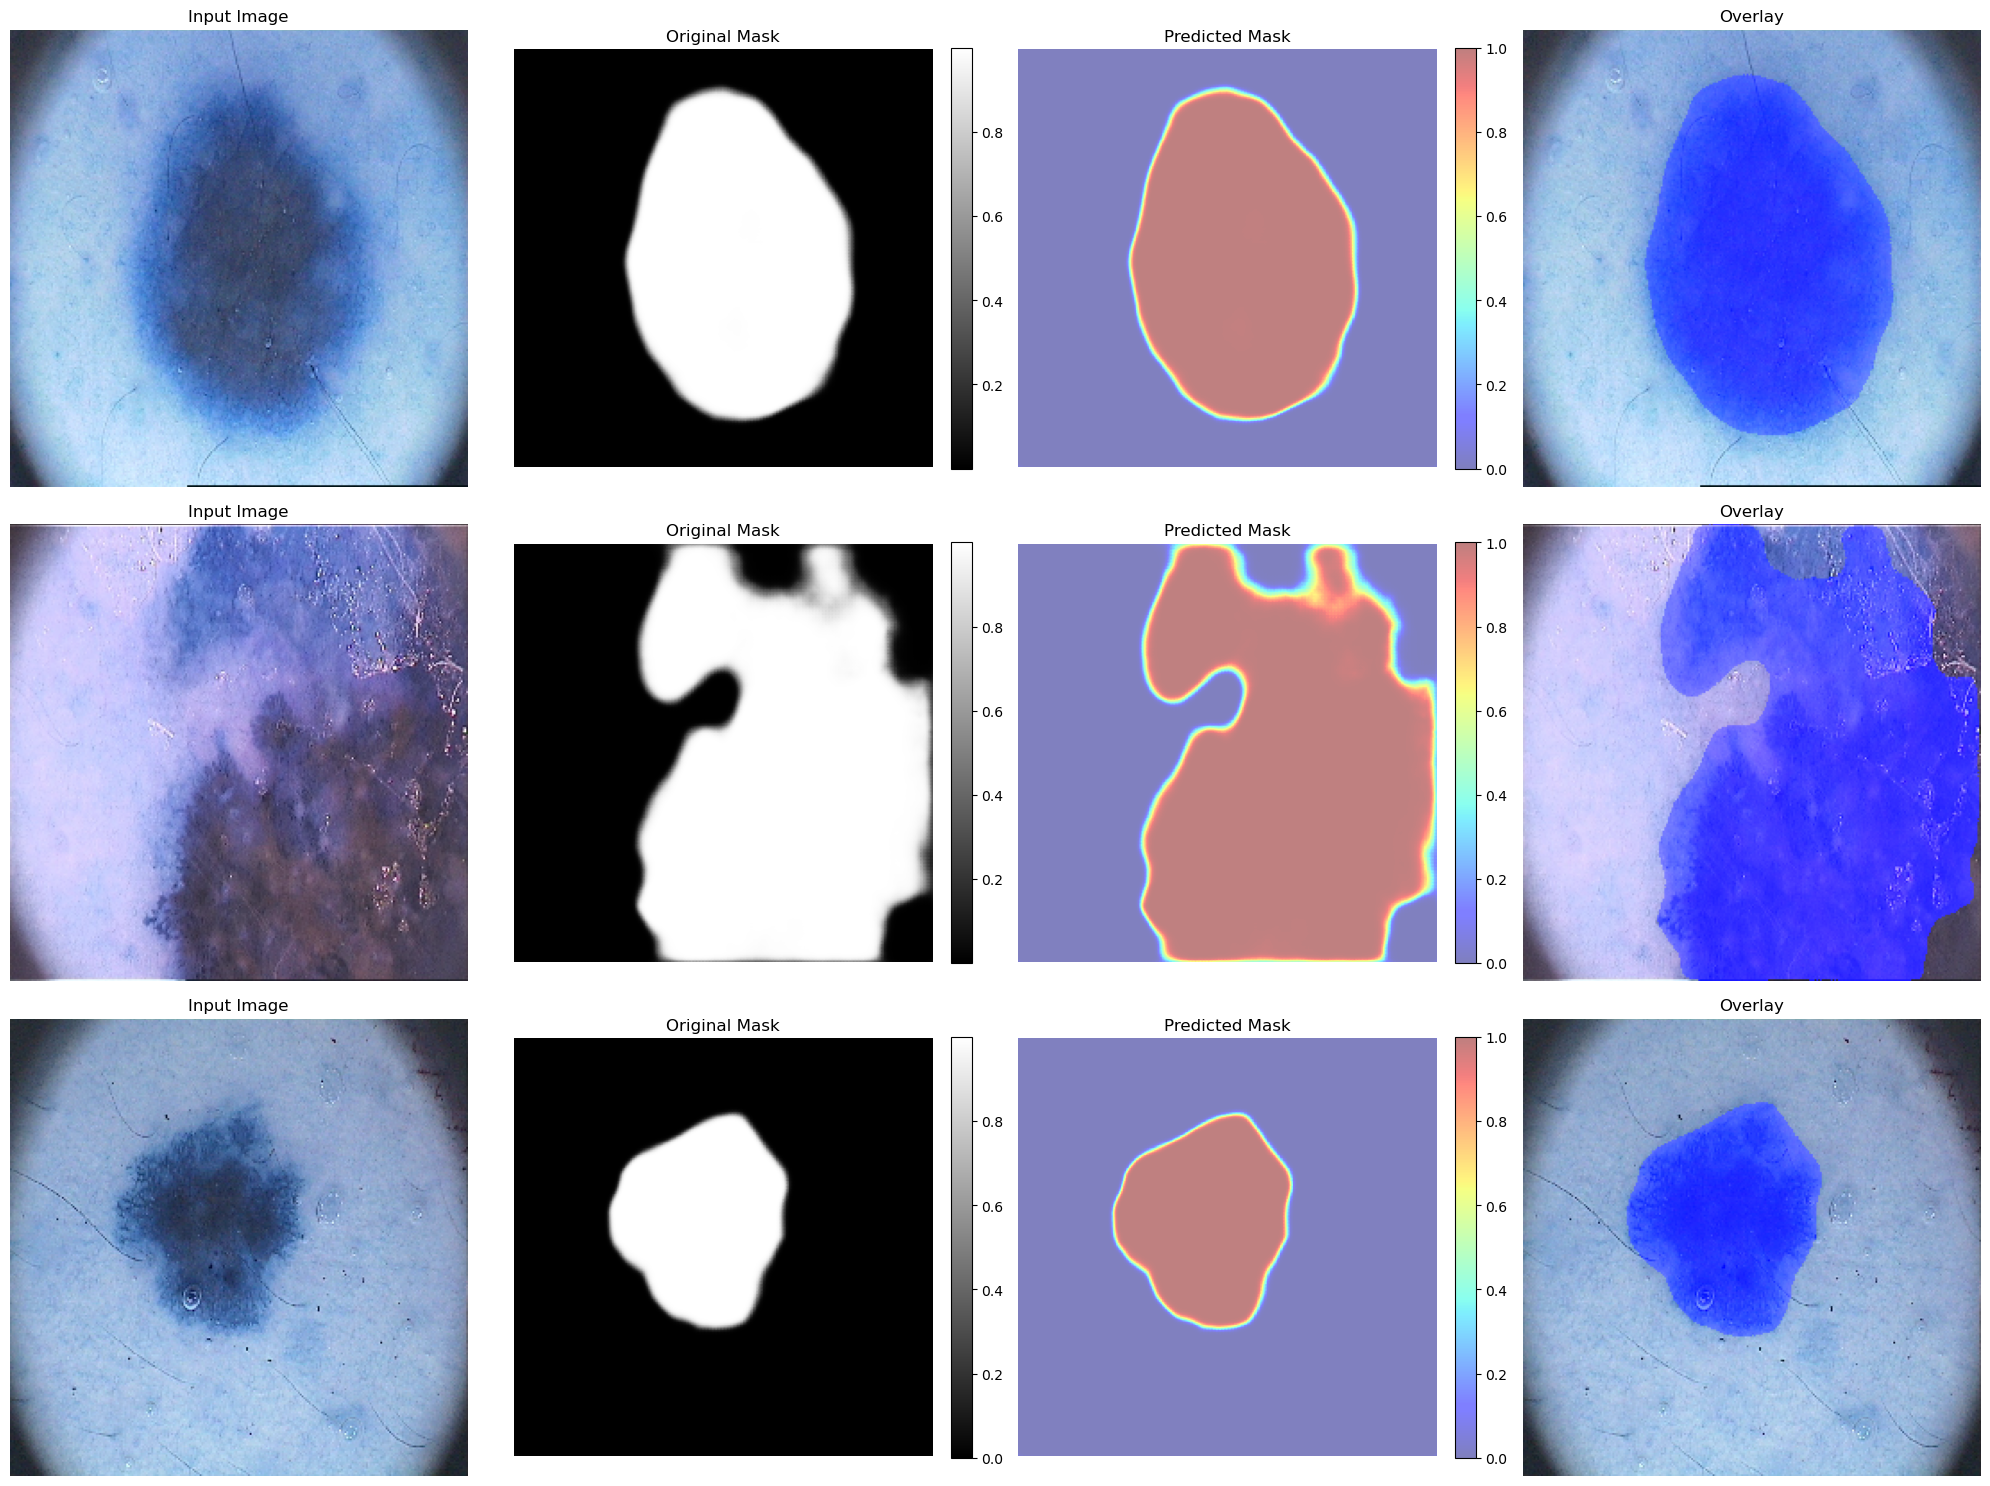

In [4]:

import cv2
import matplotlib.pyplot as plt
def visualize_segmentation_result(image, mask, ax):
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Input Image")
    ax[0].axis('off')
    
    ax[1].imshow(mask.squeeze(), cmap='gray')
    ax[1].set_title("Original Mask")
    ax[1].axis('off')
    ax[1].figure.colorbar(ax[1].images[0], ax=ax[1], orientation='vertical', fraction=0.046, pad=0.04)
    
    resized_mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
    resized_mask = (resized_mask - resized_mask.min()) / (resized_mask.max() - resized_mask.min())
    
    ax[2].imshow(resized_mask.squeeze(), cmap='jet', alpha=0.5)
    ax[2].set_title("Predicted Mask")
    ax[2].axis('off')
    ax[2].figure.colorbar(ax[2].images[0], ax=ax[2], orientation='vertical', fraction=0.046, pad=0.04)
    
    overlay = image.copy()
    overlay[resized_mask > 0.5] = [255, 0, 0]
    blended_image = cv2.addWeighted(image, 0.7, overlay, 0.3, 0)
    ax[3].imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
    ax[3].set_title("Overlay")
    ax[3].axis('off')

# Choose 3 random samples from the validation set
num_samples = 3
sample_indices = np.random.randint(0, len(val_images), num_samples)

# Create a figure to display results for all samples
fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))

for i, sample_index in enumerate(sample_indices):
    sample_image = val_images[sample_index]
    sample_mask = val_masks[sample_index]
    
    predicted_mask = model.predict(np.expand_dims(sample_image, axis=0))[0]
    
    visualize_segmentation_result(sample_image, predicted_mask, axes[i])

plt.tight_layout()
plt.show()


dict_keys(['loss', 'iou_metric', 'val_loss', 'val_iou_metric'])


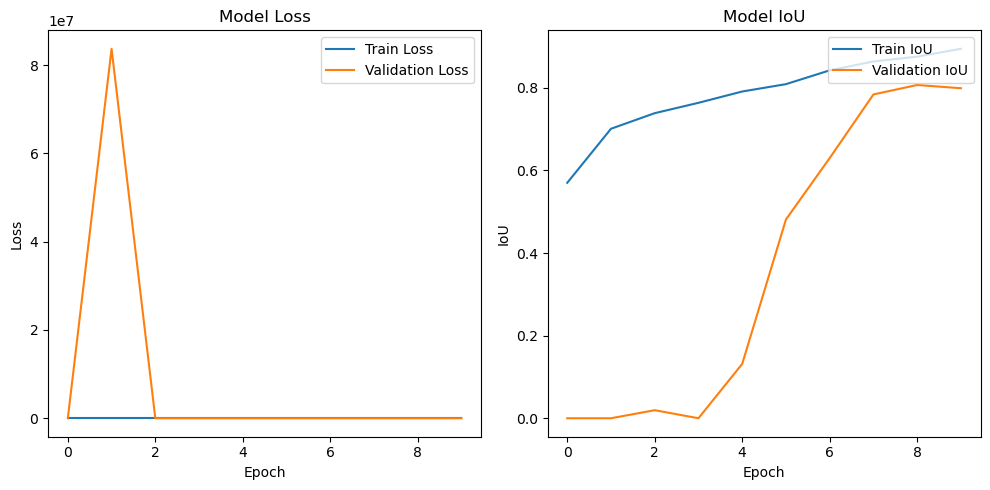

In [5]:
import matplotlib.pyplot as plt

# Check history keys to verify metric names
print(history.history.keys())

# Plotting training & validation loss, IoU, and accuracy values
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot IoU
plt.subplot(1, 3, 2)
plt.plot(history.history['iou_metric'], label='Train IoU')
plt.plot(history.history['val_iou_metric'], label='Validation IoU')
plt.title('Model IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend(loc='upper right')

# Plot accuracy if applicable
# Note: Replace 'accuracy' and 'val_accuracy' with the actual metric names if different
if 'accuracy' in history.history:
    plt.subplot(1, 3, 3)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [7]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras import backend as K
import os
import matplotlib.pyplot as plt

def load_data(data_dir, target_size=(256, 256)):
    images = []
    masks = []
    
    image_dir = os.path.join(data_dir, 'trainx')
    mask_dir = os.path.join(data_dir, 'trainy')
    
    for filename in os.listdir(image_dir):
        if filename.endswith('.bmp'):
            img_path = os.path.join(image_dir, filename)
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            images.append(img_array)
            
            mask_filename = filename.replace('.bmp', '_lesion.bmp')
            mask_path = os.path.join(mask_dir, mask_filename)
            mask = load_img(mask_path, target_size=target_size, color_mode="grayscale")
            mask_array = img_to_array(mask)
            masks.append(mask_array)
            
    return np.array(images), np.array(masks)

# Update data_dir to point to the correct location on your system
data_dir = 'C:\\Users\\Pujari\\Downloads\\archive (1)\\ph2_dataset'
images, masks = load_data(data_dir)

images = images / 255.0
masks = masks / 255.0

# Split the dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# Data augmentation
data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Define Dice coefficient and Dice loss


# Build the model
def build_model(input_shape):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    for layer in base_model.layers[-4:]:  # Fine-tune the last 4 layers
        layer.trainable = True
    
    conv1 = base_model.get_layer('conv3_block12_concat').output
    conv2 = base_model.get_layer('conv4_block24_concat').output
    conv3 = base_model.get_layer('conv5_block16_concat').output
    
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv3)
    concat1 = concatenate([up1, conv2], axis=-1)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat1)
    
    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)
    concat2 = concatenate([up2, conv1], axis=-1)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat2)
    
    output = Conv2D(1, (1, 1), activation='sigmoid')(conv5)
    
    model1 = Model(inputs=base_model.input, outputs=output)
    return model1

model1 = build_model((256, 256, 3))
model1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[iou_metric])

# Set up callbacks
checkpoint = ModelCheckpoint('skin_lesion_segmentation.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# Resize masks for training using TensorFlow
import tensorflow as tf
y_train_resized = np.array([tf.image.resize(mask, (32, 32)).numpy() for mask in y_train])
y_val_resized = np.array([tf.image.resize(mask, (32, 32)).numpy() for mask in y_val])

# Train the model
history1 = model1.fit(X_train, y_train_resized, validation_data=(X_val, y_val_resized), batch_size=16, epochs=20, callbacks=callbacks_list)

# Access training and validation metrics


Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 0.6290 - iou_metric: 0.2492
Epoch 1: val_loss improved from inf to 0.29960, saving model to skin_lesion_segmentation.keras
10/10 [==============================] - 88s 4s/step - loss: 0.6290 - iou_metric: 0.2492 - val_loss: 0.2996 - val_iou_metric: 0.4798
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 0.3032 - iou_metric: 0.5307
Epoch 2: val_loss improved from 0.29960 to 0.21418, saving model to skin_lesion_segmentation.keras
10/10 [==============================] - 35s 4s/step - loss: 0.3032 - iou_metric: 0.5307 - val_loss: 0.2142 - val_iou_metric: 0.6797
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.2069 - iou_metric: 0.6772
Epoch 3: val_loss improved from 0.21418 to 0.16581, saving model to skin_lesion_segmentation.keras
10/10 [==============================] - 37s 4s/step - loss: 0.2069 - iou_metric: 0.6772 - val_loss: 0.1658 - val_iou_metric: 0.7337
Epoch 4/20
10/10 [==

KeyError: 'accuracy'

In [12]:
training_loss = history1.history['loss']
validation_loss = history1.history['val_loss']








# Define IoU computation function
def compute_iou(y_true, y_pred, threshold=0.5):
    y_pred = y_pred > threshold
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    if union == 0:
        return 0
    else:
        return intersection / union

# Function to find the best threshold
def find_best_threshold(y_true, y_pred, thresholds):
    best_threshold = 0.5
    best_iou = 0
    for threshold in thresholds:
        ious = [compute_iou(true, pred, threshold) for true, pred in zip(y_true, y_pred)]
        mean_iou = np.mean(ious)
        if mean_iou > best_iou:
            best_iou = mean_iou
            best_threshold = threshold
    return best_threshold, best_iou

# Predict the masks on the validation set
y_val_pred = model1.predict(X_val)

# Find the best threshold
thresholds = np.linspace(0.1, 0.9, 9)
best_threshold, best_iou = find_best_threshold(y_val_resized, y_val_pred, thresholds)
print("Best Threshold: {:.2f}".format(best_threshold))
print("Best Mean IoU: {:.2f}".format(best_iou))

# Post-process masks
def post_process_mask(mask, threshold=0.5):
    mask = mask > threshold
    mask = mask.astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(mask)
    cv2.drawContours(mask, contours, -1, (1), thickness=cv2.FILLED)
    return mask

y_val_pred_post = np.array([post_process_mask(pred, best_threshold) for pred in y_val_pred])

# Compute IoU for each prediction
ious = [compute_iou(true, pred) for true, pred in zip(y_val_resized, y_val_pred_post)]
mean_iou = np.mean(ious)
print("Mean IoU after post-processing: {:.2f}".format(mean_iou))
model1.save('2nd.h5')

2/2 [==============================] - 4s 709ms/step
Best Threshold: 0.30
Best Mean IoU: 0.88
Mean IoU after post-processing: 0.88


c:\Users\Pujari\Anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 191ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 148ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 151ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


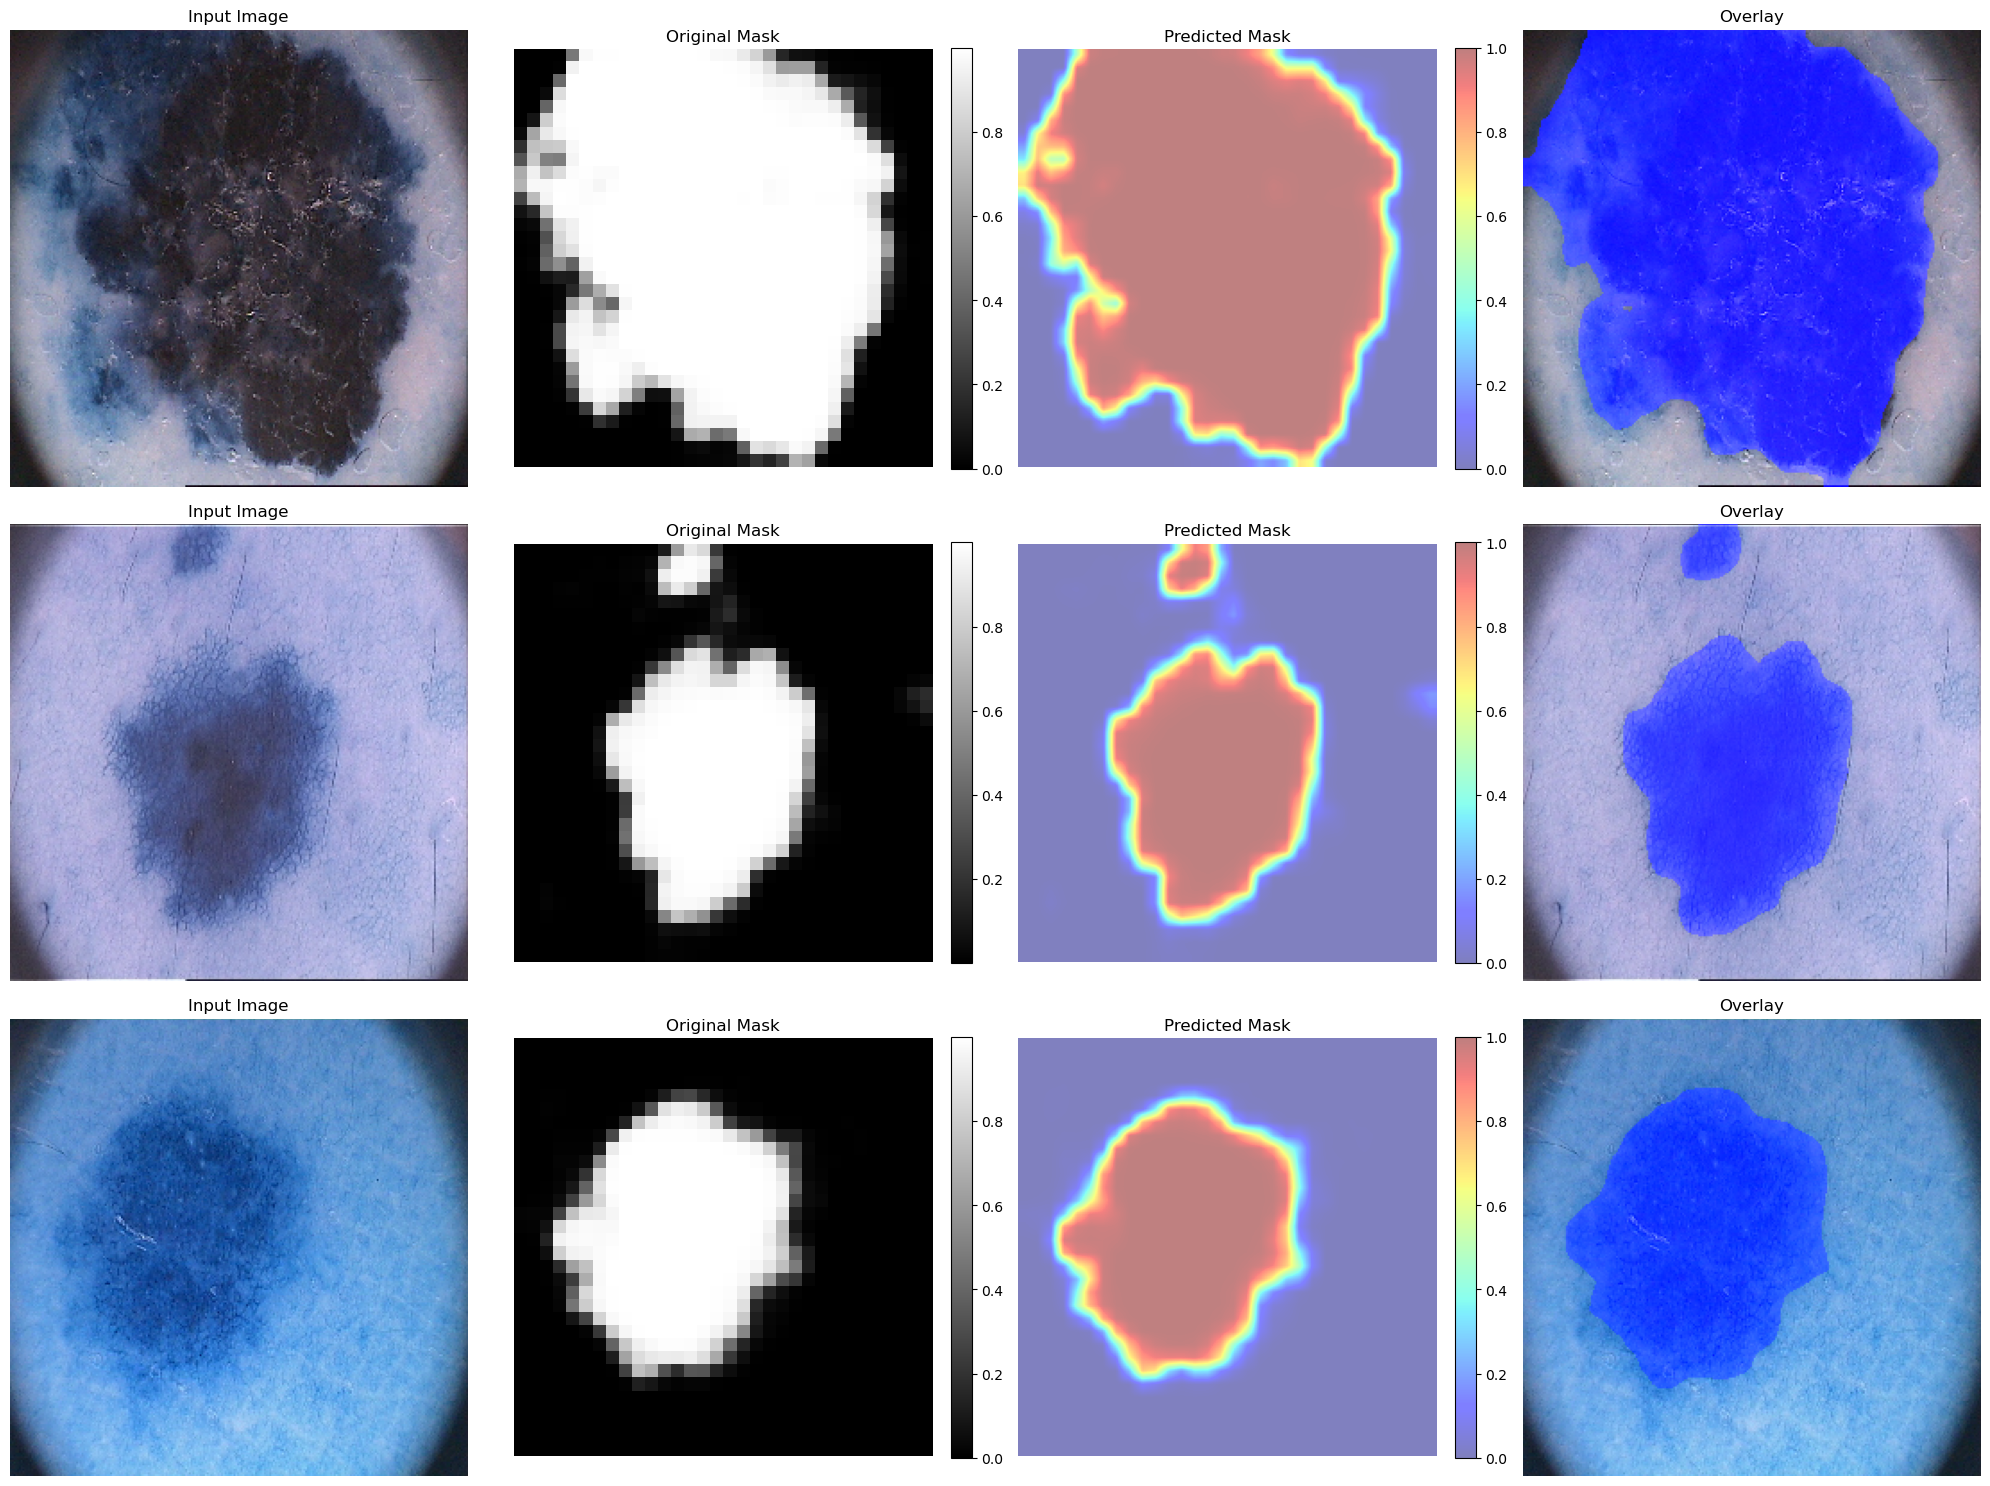

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def visualize_segmentation_result(image, mask, ax):
    # Display the input image
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Input Image")
    ax[0].axis('off')
    
    # Display the original mask
    ax[1].imshow(mask.squeeze(), cmap='gray')
    ax[1].set_title("Original Mask")
    ax[1].axis('off')
    ax[1].figure.colorbar(ax[1].images[0], ax=ax[1], orientation='vertical', fraction=0.046, pad=0.04)
    
    # Resize the predicted mask to match the size of the input image
    resized_mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
    # Ensure the mask is in the range [0, 1]
    resized_mask = (resized_mask - resized_mask.min()) / (resized_mask.max() - resized_mask.min())
    
    # Display the predicted mask
    ax[2].imshow(resized_mask.squeeze(), cmap='jet', alpha=0.5)
    ax[2].set_title("Predicted Mask")
    ax[2].axis('off')
    ax[2].figure.colorbar(ax[2].images[0], ax=ax[2], orientation='vertical', fraction=0.046, pad=0.04)
    
    # Overlay the mask on the original image
    overlay = image.copy()
    overlay[resized_mask > 0.5] = [255, 0, 0]  # Highlight mask regions in red
    blended_image = cv2.addWeighted(image, 0.7, overlay, 0.3, 0)
    ax[3].imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
    ax[3].set_title("Overlay")
    ax[3].axis('off')

# Choose 3 random samples from the validation set
num_samples = 3
sample_indices = np.random.randint(0, len(X_val), num_samples)

# Create a figure to display results for all samples
fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))

for i, sample_index in enumerate(sample_indices):
    sample_image = X_val[sample_index]
    sample_mask = y_val_resized[sample_index]
    
    # Predict the mask using the model
    predicted_mask = model1.predict(np.expand_dims(sample_image, axis=0))[0]
    
    # Visualize the segmentation result
    visualize_segmentation_result(sample_image, predicted_mask, axes[i])

plt.tight_layout()
plt.show()


dict_keys(['loss', 'iou_metric', 'val_loss', 'val_iou_metric'])


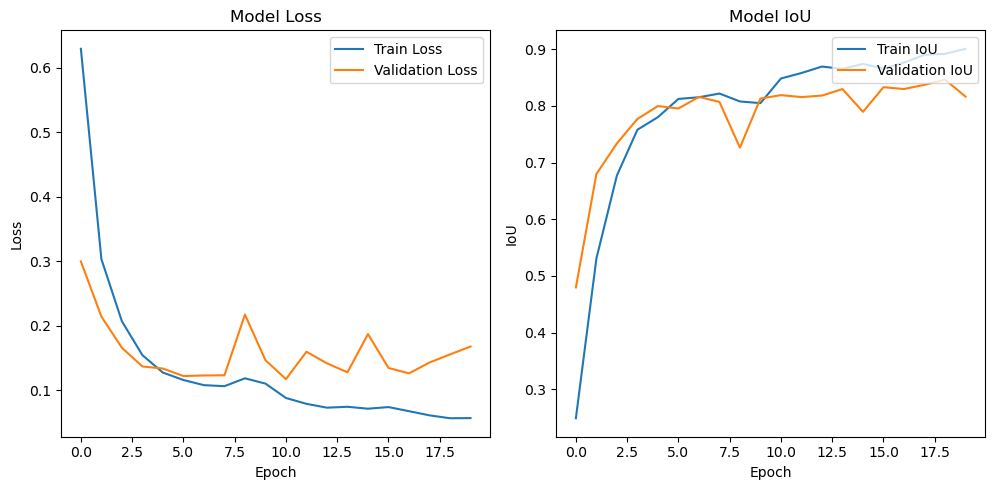

In [14]:
import matplotlib.pyplot as plt

# Check history keys to verify metric names
print(history1.history.keys())

# Plotting training & validation loss, IoU, and accuracy values
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot IoU
plt.subplot(1, 3, 2)
plt.plot(history1.history['iou_metric'], label='Train IoU')
plt.plot(history1.history['val_iou_metric'], label='Validation IoU')
plt.title('Model IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend(loc='upper right')

# Plot accuracy if applicable
# Note: Replace 'accuracy' and 'val_accuracy' with the actual metric names if different
if 'accuracy' in history.history:
    plt.subplot(1, 3, 3)
    plt.plot(history1.history['accuracy'], label='Train Accuracy')
    plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

plt.tight_layout()
plt.show()
